In [66]:
%matplotlib inline
import numpy as np
import pandas as pd
import pywt
import seaborn as sns
import scaleogram as scg 
import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
from mat4py import loadmat
from scipy.fftpack import fft
import wfdb
import re
from math import *

In [53]:
sample_size=5000

# Read source for create a dataset of annotations
Source : https://physionet.org/content/butqdb/1.0.0/

In [165]:
# source wfdb
header_list = ["start1", "end1", "class1","start2", "end2", "class2","start3", "end3", "class3","start", "end", "class"]
record_list = wfdb.get_record_list('butqdb')
dataannall = pd.DataFrame(columns=header_list)
for rcd in record_list:
    if re.search(r'ECG$', rcd):
        record_name = f"../aura-data/{rcd}"
        print(record_name, end="\r")
        record_csv = f"../aura-data/{rcd.replace('ECG','ANN')}.csv"
        dataann = pd.read_csv(record_csv, names=header_list)
        dataannall = pd.concat([dataannall,dataann.assign(record=rcd.split('/')[0])], ignore_index=True)
#Add columns to dataset
dataannall['signal_length']=dataannall['end'] - dataannall['start']
dataannall["sample"]=round(dataannall["signal_length"]/sample_size)
dataset = dataannall[dataannall["class"].notnull() & dataannall["start"].notnull() & dataannall["end"].notnull() ]



In [166]:
dataset.head()

,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class,record,signal_length,sample
0,1.0,198867.0,2.0,1.0,19525.0,1.0,1,7047,2,1.0,7047.0,2.0,100001,7046.0,1.0
1,198868.0,320282.0,1.0,19526.0,28694.0,2.0,7048,17209,1,7048.0,17209.0,1.0,100001,10161.0,2.0
2,320283.0,373109.0,2.0,28695.0,32739.0,1.0,17210,28390,2,17210.0,28694.0,2.0,100001,11484.0,2.0
3,373110.0,2197974.0,1.0,32740.0,96699.0,2.0,28391,32653,1,28695.0,32653.0,1.0,100001,3958.0,1.0
4,2197975.0,2582746.0,2.0,96700.0,110564.0,1.0,32654,71061,2,32654.0,112474.0,2.0,100001,79820.0,16.0


In [167]:
dataset.describe()

,start1,end1,class1,start2,end2,class2,start,end,class,signal_length,sample
count,2.076000e+03,2.076000e+03,2076.000000,4.305000e+03,4.305000e+03,4305.000000,7.154000e+03,7.154000e+03,7154.000000,7.154000e+03,7154.000000
mean,5.735894e+07,5.817328e+07,1.748073,5.950179e+07,5.987307e+07,1.572590,5.601431e+07,5.625521e+07,1.604417,2.409030e+05,48.144255
std,3.225315e+07,3.202552e+07,0.731805,3.072217e+07,3.057915e+07,0.603114,2.802337e+07,2.796447e+07,0.609641,2.530322e+06,506.072488
min,1.000000e+00,1.988670e+05,0.000000,1.000000e+00,1.952500e+04,0.000000,1.000000e+00,7.047000e+03,0.000000,3.020000e+02,0.000000
25%,2.961164e+07,2.970962e+07,1.000000,3.180192e+07,3.216237e+07,1.000000,3.405290e+07,3.411941e+07,1.000000,2.264250e+03,0.000000
50%,5.676074e+07,5.760000e+07,2.000000,5.791413e+07,5.792801e+07,2.000000,5.507225e+07,5.570303e+07,2.000000,5.853000e+03,1.000000
75%,7.522529e+07,7.664065e+07,2.000000,7.722608e+07,7.766738e+07,2.000000,6.858724e+07,6.945778e+07,2.000000,1.982150e+04,4.000000
max,1.391201e+08,1.391470e+08,3.000000,1.391468e+08,1.391470e+08,3.000000,1.391201e+08,1.391470e+08,3.000000,7.464800e+07,14930.000000


In [168]:
dataset.sort_values(by=['signal_length']).head(10)

,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class,record,signal_length,sample
2164,29830121.0,29843829.0,2.0,29833497.0,29842799.0,2.0,29041071,29041373,2,29041071.0,29041373.0,2.0,104001,302.0,0.0
6902,NaN,NaN,NaN,NaN,NaN,NaN,22772239,22806837,1,42187296.0,42187599.0,2.0,111001,303.0,0.0
14215,57653762.0,57664665.0,1.0,29052794.0,29058124.0,1.0,28815944,28816279,1,28871845.0,28872149.0,1.0,121001,304.0,0.0
1961,29896114.0,29909814.0,1.0,29430978.0,29432026.0,2.0,29201971,29203041,2,29367658.0,29367979.0,2.0,103003,321.0,0.0
14982,NaN,NaN,NaN,65811759.0,65824014.0,3.0,58413007,58414129,1,65500416.0,65500737.0,2.0,124001,321.0,0.0
15543,57711177.0,57779132.0,1.0,29622202.0,29624040.0,1.0,28902711,29014385,1,29637312.0,29637634.0,1.0,126001,322.0,0.0
2087,NaN,NaN,NaN,NaN,NaN,NaN,29712177,29713943,2,29974330.0,29974654.0,2.0,103003,324.0,0.0
1347,NaN,NaN,NaN,29422321.0,29423807.0,2.0,2.95904e+07,2.95909e+07,2,29583767.0,29584095.0,2.0,100002,328.0,0.0
15582,NaN,NaN,NaN,57917191.0,57917810.0,2.0,57655491,57655835,2,58410626.0,58410956.0,2.0,126001,330.0,0.0
14943,NaN,NaN,NaN,65570247.0,65579982.0,1.0,58189527,58190516,2,65289466.0,65289798.0,2.0,124001,332.0,0.0


In [42]:
dataannall.sort_values(by=['sample'],ascending=False).head(10)

,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class,record,signal_length,sample
14558,NaN,NaN,NaN,NaN,NaN,NaN,29981332,29991362,2,58800001.0,133448000.0,0.0,123001,74647999.0,7465.0
14419,NaN,NaN,NaN,NaN,NaN,NaN,58497423,58499060,1,58800001.0,122798000.0,0.0,122001,63997999.0,6400.0
2299,1.0,47323379.0,3.0,1.0,47323871.0,3.0,1,47323500,3,1.0,47323500.0,3.0,105001,47323499.0,4732.0
15596,NaN,NaN,NaN,58407654.0,58408005.0,2.0,57821475,57824016,2,58800001.0,92361000.0,0.0,126001,33560999.0,3356.0
13716,57600001.0,58800000.0,1.0,29389929.0,29392545.0,2.0,28903735,28905450,2,58800001.0,91651000.0,0.0,114001,32850999.0,3285.0
14375,NaN,NaN,NaN,NaN,NaN,NaN,58662590,58670947,1,58800001.0,91233000.0,0.0,121001,32432999.0,3243.0
13539,NaN,NaN,NaN,NaN,NaN,NaN,36544236,36546336,1,58800001.0,91148000.0,0.0,113001,32347999.0,3235.0
14073,NaN,NaN,NaN,58800001.0,89091000.0,0.0,58102368,58112099,2,58800001.0,89091000.0,0.0,118001,30290999.0,3029.0
13892,NaN,NaN,NaN,NaN,NaN,NaN,58398360,58401557,1,58800001.0,87934000.0,0.0,115001,29133999.0,2913.0
13949,1.0,28800000.0,0.0,1.0,28800000.0,0.0,1,28800000,0,1.0,28800000.0,0.0,118001,28799999.0,2880.0


In [169]:
dataset.record.unique()

array(['100001', '100002', '103001', '103002', '103003', '104001',
       '105001', '111001', '113001', '114001', '115001', '118001',
       '121001', '122001', '123001', '124001', '125001', '126001'],
      dtype=object)

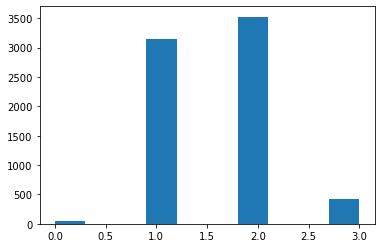

In [174]:
plt.hist(dataset['class'], bins=10);
plt.show()

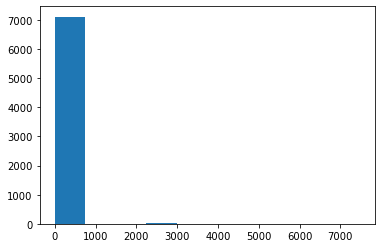

In [45]:
plt.hist(dataannall['sample'], bins=10);
plt.show()

In [46]:
dataannall.dtypes

start1           float64
end1             float64
class1           float64
start2           float64
end2             float64
class2           float64
start3            object
end3              object
class3            object
start            float64
end              float64
class            float64
record            object
signal_length    float64
sample           float64
dtype: object

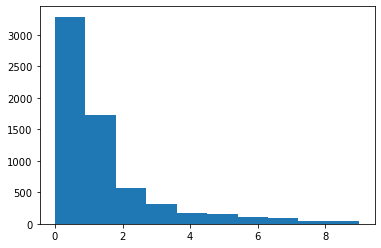

In [52]:
plt.hist(dataannall[dataannall['sample'] < 10]['sample'], bins=10);
plt.show()

In [170]:
pie_chart_data = dataset[dataset['record'] == '100001'].groupby('class')['sample'].sum()
pie_chart_data.shape

(3,)

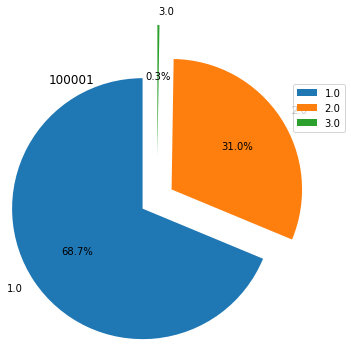

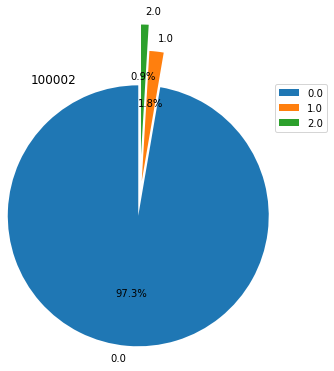

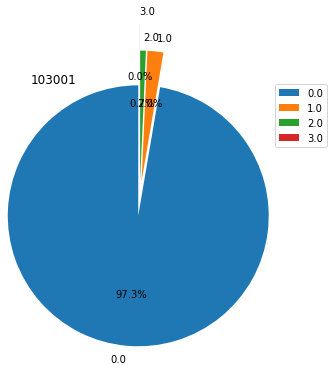

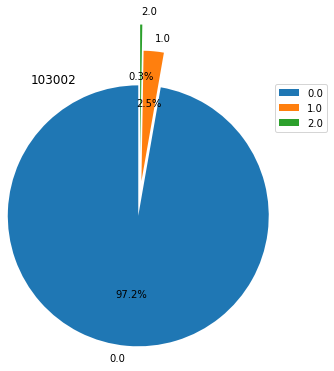

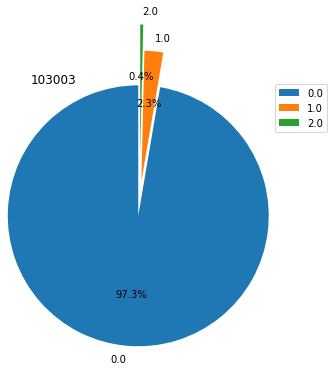

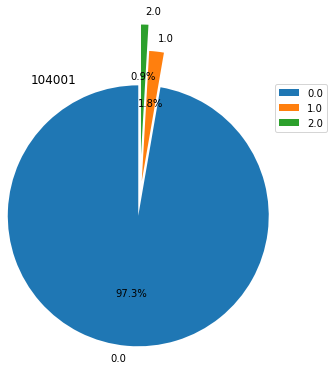

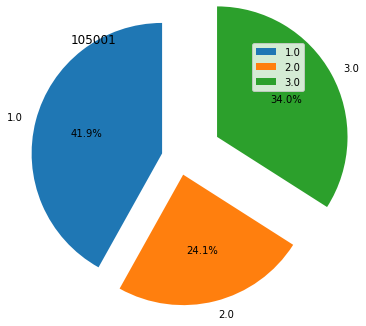

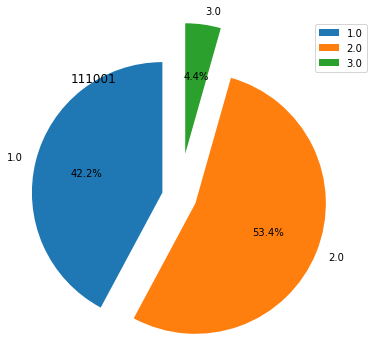

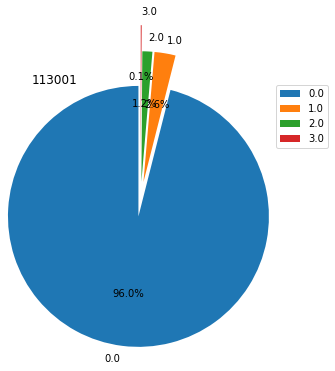

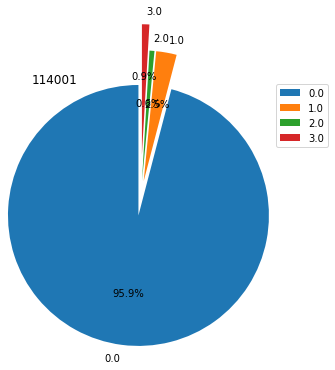

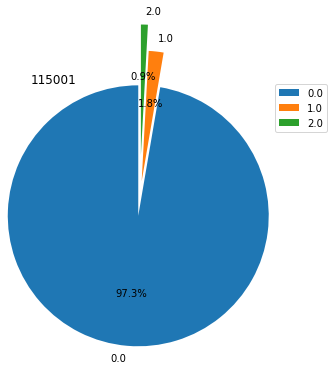

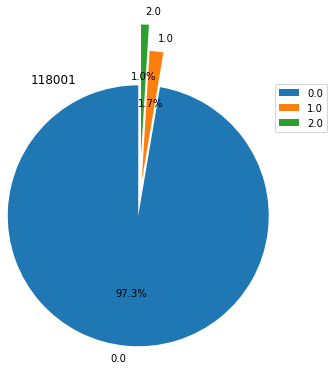

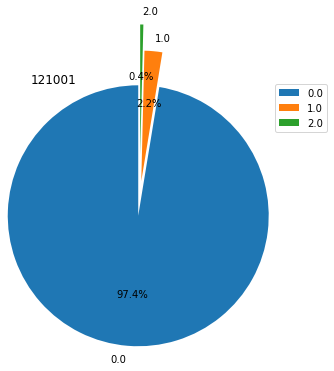

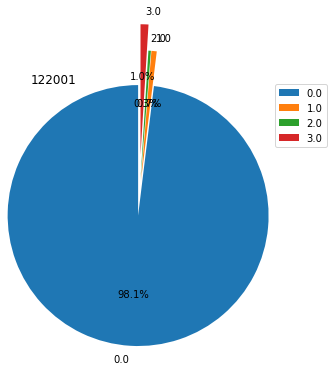

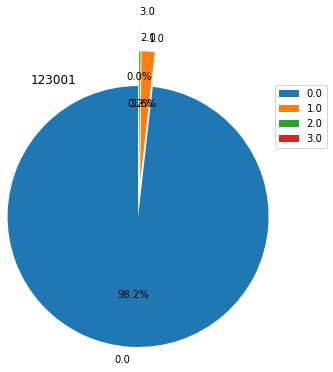

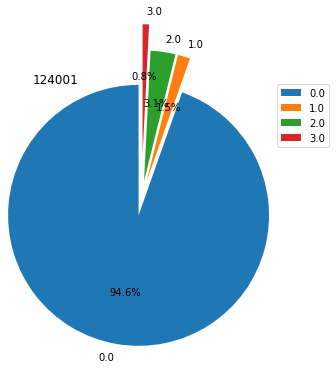

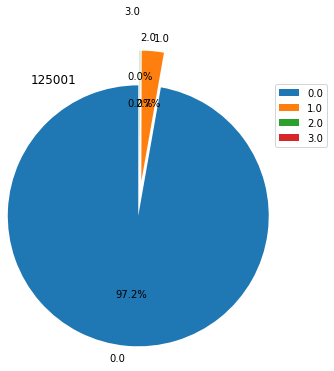

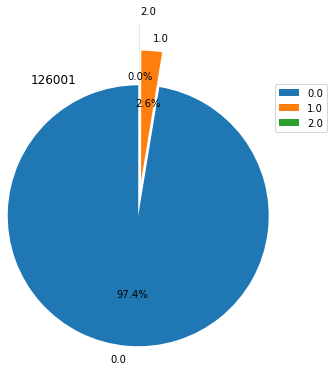

In [173]:
"""dataset['class_name'] = dataset['class'].apply(lambda x:
                                                     "Class 1: All significant waveforms" if int(x)==1 
                                                     else "Class 2: The noise level is increased" if int(x)==2
                                                     else "Class 3: The signal is unsuitable for any analysis. " if int(x)==3 
                                                     else "Class 0: The quality was not annotated ")
"""
for patient in dataannall.record.unique():
    pie_chart_data = dataset[dataset['record'] == patient].groupby('class')['sample'].sum()
    if pie_chart_data.shape[0] == 3:
        explode = (0.2,0.2,0.5)
    else:
        explode = (0.2,0.2,0.2,0.5)
    
    plt.figure()
    plt.pie(pie_chart_data.values, labels=pie_chart_data.index,  
           autopct='%1.1f%%',
           shadow=False, 
           startangle=90,
           explode=explode,
           radius=1.5
           )
    plt.title(patient, fontdict=None,loc='left')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

# Read source and create 2 lists
ecg_data : data
ecg_labels : labels quality class (1, 2 or 3; 0 means the quality was not annotated in this segment) 
Source : https://physionet.org/content/butqdb/1.0.0/

In [177]:
#For cut sample into n sample with cut_size
def ecgreshape(ecg_array,cut_size):
    ecg_size_multi = ceil(ecg_array.shape[0]/cut_size)
    ecg_result = np.zeros(ecg_size_multi*cut_size)
    ecg_result[:ecg_array.shape[0]] = ecg_array
    print(f"Array size {ecg_array.shape[0]} cut by {cut_size} done {ecg_size_multi}", end="\r")
    ecg_result = np.reshape(ecg_result, (ecg_size_multi,cut_size))
    return ecg_result


In [ ]:
# source wfdb
header_list = ["start1", "end1", "class1","start2", "end2", "class2","start3", "end3", "class3","start", "end", "class"]
record_list = wfdb.get_record_list('butqdb')
record_list =['105001/105001_ECG']
ecg_data=[np.zeros(sample_size)]
ecg_labels=[]
for rcd in record_list:
    if re.search(r'ECG$', rcd):
        record_name = f"../aura-data/{rcd}"
        print(record_name)
        record_csv = f"../aura-data/{rcd.replace('ECG','ANN')}.csv"
        for i in dataann_nan_class.index:
            record = wfdb.rdrecord(record_name, sampfrom=int(dataann_nan_class.start[i]), sampto=int(dataann_nan_class.end[i]))
            ecg_data = np.concatenate((ecg_data,ecgreshape(record.adc()[:,0],sample_size)), axis=0)
            ecg_labels.append(int(dataann_nan_class["class"][i]))

['100001/100001_ACC', '100001/100001_ECG', '100002/100002_ACC', '100002/100002_ECG', '103001/103001_ACC', '103001/103001_ECG', '103002/103002_ACC', '103002/103002_ECG', '103003/103003_ACC', '103003/103003_ECG', '104001/104001_ACC', '104001/104001_ECG', '105001/105001_ACC', '105001/105001_ECG', '111001/111001_ACC', '111001/111001_ECG', '113001/113001_ACC', '113001/113001_ECG', '114001/114001_ACC', '114001/114001_ECG', '115001/115001_ACC', '115001/115001_ECG', '118001/118001_ACC', '118001/118001_ECG', '121001/121001_ACC', '121001/121001_ECG', '122001/122001_ACC', '122001/122001_ECG', '123001/123001_ACC', '123001/123001_ECG', '124001/124001_ACC', '124001/124001_ECG', '125001/125001_ACC', '125001/125001_ECG', '126001/126001_ACC', '126001/126001_ECG']
../aura-data/105001/105001_ECG


# Scaleogram

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


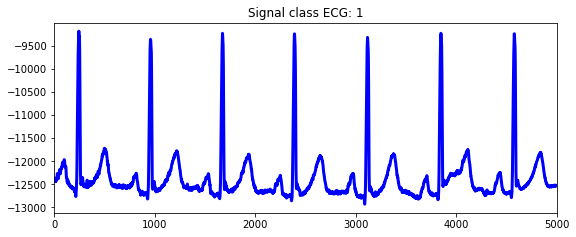

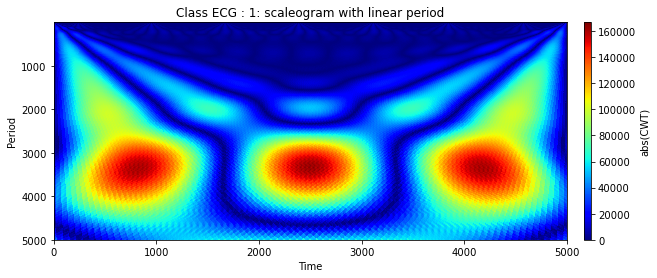

In [32]:
# choose default wavelet function 
scg.set_default_wavelet('morl')

nn = 33
signal_length = 5000
# range of scales to perform the transform
scales = scg.periods2scales( np.arange(1, signal_length+1) )
x_values_wvt_arr = range(0,len(ecg_data[nn]),1)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, ecg_data[nn], linewidth=3, color='blue')
ax1.set_xlim(0, signal_length)
ax1.set_title(f"Signal class ECG: {ecg_labels[nn]}")

# the scaleogram
scg.cws(ecg_data[nn][:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
        title=f"Class ECG {ecg_labels[nn]}: scaleogram with linear period"); 

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")

# ICI c'est le bac à sable

In [135]:
#Test to validate ecgreshape
result = np.zeros(9)
result[:a.shape[0]] = a
np.reshape(result, (3, 3))
#print(ecgreshape(a,5))
b=[[1,2,2]]
b.append([3,8,6])
b=[np.zeros(2)]
print(ecgreshape(a,2))
print(b[0].shape,ecgreshape(a,2).shape)
np.concatenate((b,ecgreshape(a,2)), axis=0)

[[1. 2.]
 [3. 4.]
 [5. 6.]
 [7. 0.]]
(2,) (4, 2)


array([[0., 0.],
       [1., 2.],
       [3., 4.],
       [5., 6.],
       [7., 0.]])

In [56]:
#Essai pour boucle while
sample_start=0
sample_end=sample_size
ex=15789
while sample_end < ex:
    print(sample_start,sample_end,sample_size)
    sample_start=sample_end
    sample_end+=sample_size

0 5000 5000
5000 10000 5000
10000 15000 5000
